# Defines and general functions

In [1]:
import os
import time
import sys
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt


def print_status(message : str):
    print("[Status]: ",message)

def print_info(message : str):
    print("[Info]: ",message)

print("Tensoflow version:", tf.version.VERSION)

2023-12-20 15:10:08.609856: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 15:10:08.685230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 15:10:08.686443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 15:10:09.896539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensoflow version: 2.13.1


# Defining and loading the dataset

[Status]:  Defining dataset directory
[Info]:  dataset_dir set to: ../getimages/imgs/
[Info]:  num of images: 4936
[Status]:  Loading dataset images
[Info]:  Images have dims: [60, 60, 1]
[Status]:  Creating dataset from images
Found 4936 files belonging to 4 classes.
Using 3949 files for training.
Found 4936 files belonging to 4 classes.
Using 987 files for validation.
[Info]:  Class names found: ['cross', 'flat', 'penta', 'square']
[Status]:  Visualizing dataset


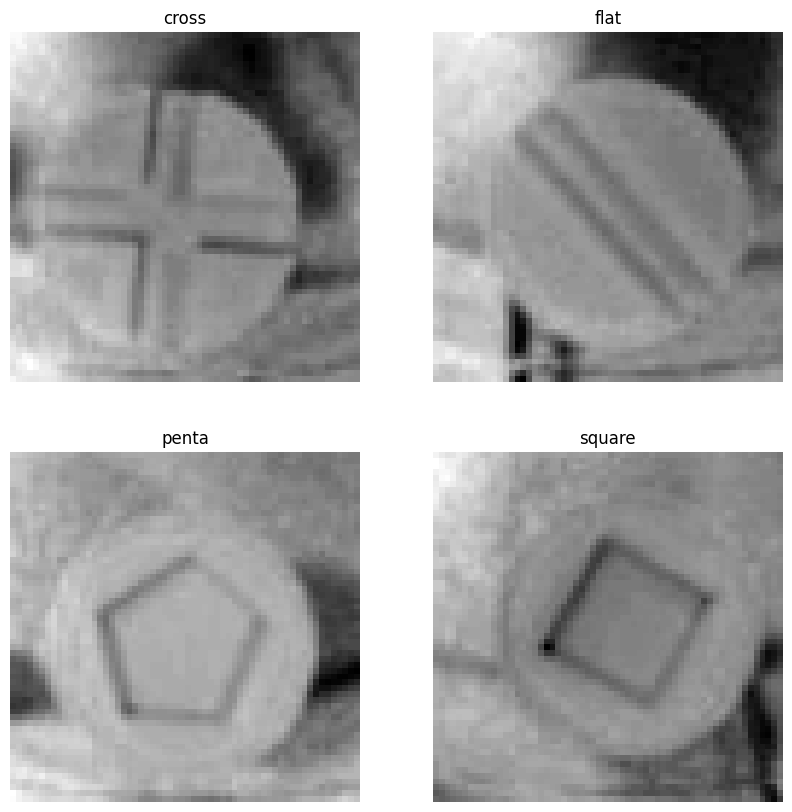

[Info]:  One traning data batch has image shape (128, 60, 60, 1)
[Info]:  One traning data batch has label shape (128,)


In [2]:
print_status("Defining dataset directory")
args = sys.argv[1:]
USE_DEFAULT_IMAGEPATH = True
if USE_DEFAULT_IMAGEPATH:
    dataset_dir = "../getimages/imgs/"
else:
    if len(args) == 2 and args[0] == '-image_path':
        dataset_dir = str(args[1])	
    else:
        dataset_dir = input("Write path to images:")
print_info(f"dataset_dir set to: {dataset_dir}")
data_dir = pathlib.Path(dataset_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print_info(f"num of images: {image_count}")

print_status("Loading dataset images")

image_types = ["cross", "flat", "penta", "square"]
image_files = {}
image_dims = []
for type in image_types:
    image_files[type] = list(data_dir.glob(type + '/*'))
for type in image_types:
    image = PIL.Image.open(str(image_files[type][0]))
    if image_dims != []:
        #height, width, num channels
        assert [image.height, image.width, len(image.getbands())] == image_dims, f"Image types does not have the same dimensions!\n {type} has {[image.height, image.width, len(image.getbands())]}, others have {image_dims}"
    else:
        image_dims = [image.height, image.width, len(image.getbands())] 
    # image.show()

# input("Press the <ENTER> key to continue...")

print_info(f"Images have dims: {image_dims}")
print_status("Creating dataset from images")

batch_size = 128
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=image_dims[0:2],
color_mode="grayscale",
batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=image_dims[0:2],
color_mode="grayscale",
batch_size=batch_size)

class_names = train_ds.class_names
print_info(f"Class names found: {class_names}")

print_status("Visualizing dataset")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    # print(labels)
    used = []
    subplot_dims = int(np.ceil(np.sqrt(len(class_names))))
    for i, label in enumerate(labels[:-1]):
        # print(i, labels[i].numpy().astype("uint8"))
        if labels[i].numpy().astype("uint8") not in used:
            ax = plt.subplot(subplot_dims, subplot_dims, labels[i].numpy().astype("uint8") + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
            plt.title(class_names[labels[i]])
            plt.axis("off")
            used.append(labels[i].numpy().astype("uint8"))
plt.show()


for image_batch, labels_batch in train_ds:
    print_info(f"One traning data batch has image shape {image_batch.shape}")
    print_info(f"One traning data batch has label shape {labels_batch.shape}")
    break


# Optimization of dataset

In [3]:

print_status("Normalizing pixel values from [0, 255] to [0, 1]")
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print_info(f"Example result: {np.min(first_image), np.max(first_image)}")

print_status("Enabling caching and prefetching of dataset for traning and validation")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

[Status]:  Normalizing pixel values from [0, 255] to [0, 1]
[Info]:  Example result: (0.28235295, 0.5803922)
[Status]:  Enabling caching and prefetching of dataset for traning and validation


# Either load or create model

In [4]:
LOAD_EXISTING_MODEL = False
FIT_MODEL = True
SAVE_MODEL = True

## Load model

In [5]:
if LOAD_EXISTING_MODEL:
    new_model = tf.keras.models.load_model('my_model.tf')

    # Show the model architecture
    new_model.summary()

In [6]:
# Evaluate the restored model
if LOAD_EXISTING_MODEL:
    loss, acc = new_model.evaluate(val_ds, verbose=2)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print(new_model.predict(val_ds).shape)

### Set model to loaded model

In [7]:
if LOAD_EXISTING_MODEL:
    model = new_model

## Create model

### Add data augmentation to ramdomly rotate, flip and zoom images

In [8]:
data_augmentation = keras.Sequential(
    [
    keras.layers.RandomFlip(mode="horizontal_and_vertical", input_shape=image_dims),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    ]
)

#### Show example

2023-12-20 15:10:15.121846: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


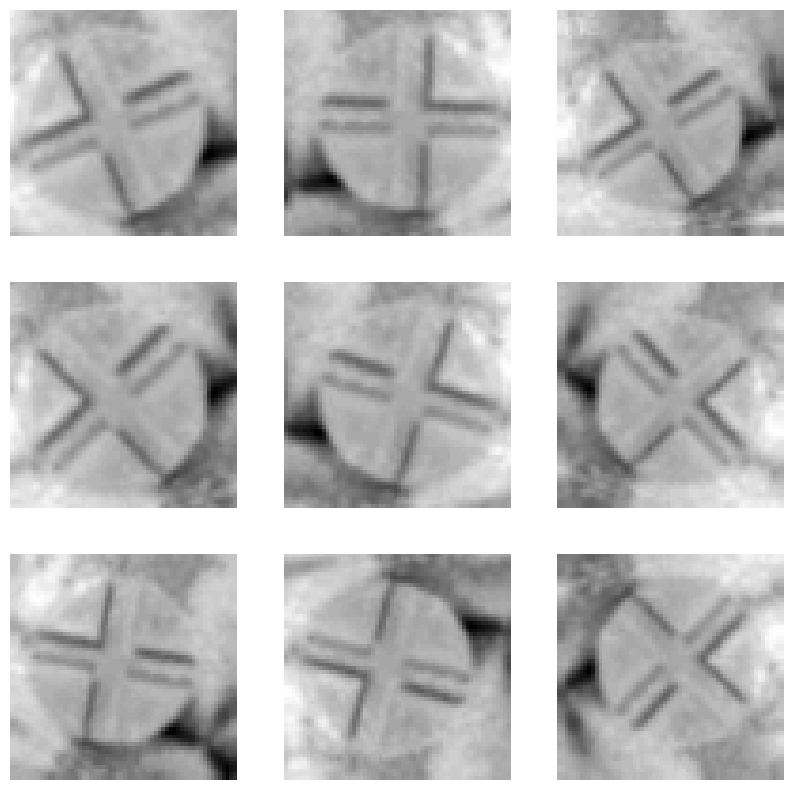

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

### Model definition

In [10]:
if not LOAD_EXISTING_MODEL:
    print_status("Defining model")

    num_classes = len(class_names)

    model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), activation='relu', input_shape=image_dims),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', use_bias=True),
    tf.keras.layers.Dense(32, activation='relu', use_bias=True),
    tf.keras.layers.Dense(16, activation='relu', use_bias=True),
    tf.keras.layers.Dense(num_classes)
    ])

    print_status("Configuring model")

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

[Status]:  Defining model
[Status]:  Configuring model


# Model fitting

In [11]:
if LOAD_EXISTING_MODEL:
    total_epochs = 60
else:
    total_epochs = 0

In [12]:
if FIT_MODEL:
    epochs = 60
    print_status("Fitting model")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )
    total_epochs += epochs

    # input("Press the <ENTER> key to close the program...")
else:
    history = None
print(total_epochs)

[Status]:  Fitting model
Epoch 1/60
31/31 [==============================] - 13s 331ms/step - loss: 1.3859 - accuracy: 0.2702 - val_loss: 1.3855 - val_accuracy: 0.2817
Epoch 2/60
31/31 [==============================] - 11s 362ms/step - loss: 1.3854 - accuracy: 0.2702 - val_loss: 1.3853 - val_accuracy: 0.2817
Epoch 3/60
31/31 [==============================] - 10s 308ms/step - loss: 1.3853 - accuracy: 0.2702 - val_loss: 1.3850 - val_accuracy: 0.2817
Epoch 4/60
31/31 [==============================] - 9s 285ms/step - loss: 1.3852 - accuracy: 0.2702 - val_loss: 1.3848 - val_accuracy: 0.2817
Epoch 5/60
31/31 [==============================] - 9s 285ms/step - loss: 1.3850 - accuracy: 0.2702 - val_loss: 1.3843 - val_accuracy: 0.2817
Epoch 6/60
31/31 [==============================] - 9s 288ms/step - loss: 1.3845 - accuracy: 0.2702 - val_loss: 1.3824 - val_accuracy: 0.2817
Epoch 7/60
31/31 [==============================] - 9s 284ms/step - loss: 1.3767 - accuracy: 0.2912 - val_loss: 1.3360 -

### Summarise model

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60, 60, 1)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 60, 60, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                 

In [14]:
for layer in model.layers:
    weights_n_bias = layer.get_weights()
    if weights_n_bias != []:
        weights = weights_n_bias[0]
        
        layer_dims = weights.shape
        
        bias = weights_n_bias[1]
        
        bias_dims = bias.shape
        print(layer.name, "weights dims:", layer_dims, "bias dims:", bias_dims)

conv2d weights dims: (3, 3, 1, 32) bias dims: (32,)
conv2d_1 weights dims: (3, 3, 32, 32) bias dims: (32,)
conv2d_2 weights dims: (3, 3, 32, 32) bias dims: (32,)
conv2d_3 weights dims: (3, 3, 32, 16) bias dims: (16,)
dense weights dims: (16, 64) bias dims: (64,)
dense_1 weights dims: (64, 32) bias dims: (32,)
dense_2 weights dims: (32, 16) bias dims: (16,)
dense_3 weights dims: (16, 4) bias dims: (4,)


### Show training history

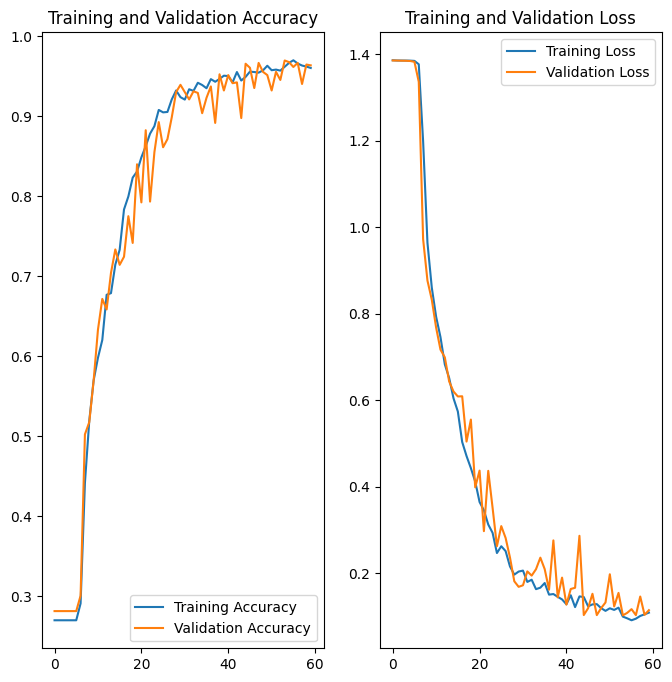

In [15]:
if history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Evaluating model

In [16]:
print_status("Evaluating model")
train_loss, train_acc = model.evaluate(train_ds, verbose=2)

print_info(f"Accuracy on training data: {train_acc}")

val_loss, val_acc = model.evaluate(val_ds, verbose=2)

print_info(f"Accuracy on validation data: {val_acc}")

[Status]:  Evaluating model
31/31 - 2s - loss: 0.0870 - accuracy: 0.9668 - 2s/epoch - 69ms/step
[Info]:  Accuracy on training data: 0.9668270349502563
8/8 - 0s - loss: 0.1152 - accuracy: 0.9635 - 478ms/epoch - 60ms/step
[Info]:  Accuracy on validation data: 0.9635258316993713


# Testing inference

In [17]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_ds)
predictions.shape

8/8 [==============================] - 1s 65ms/step


(987, 4)

In [18]:
predictions[0]
prediction_class = np.argmax(predictions[0])
class_names[prediction_class]

'penta'

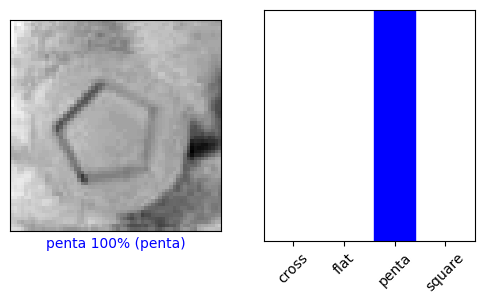

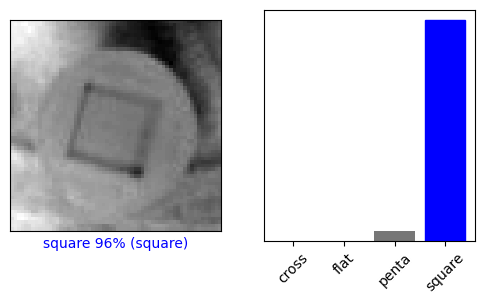

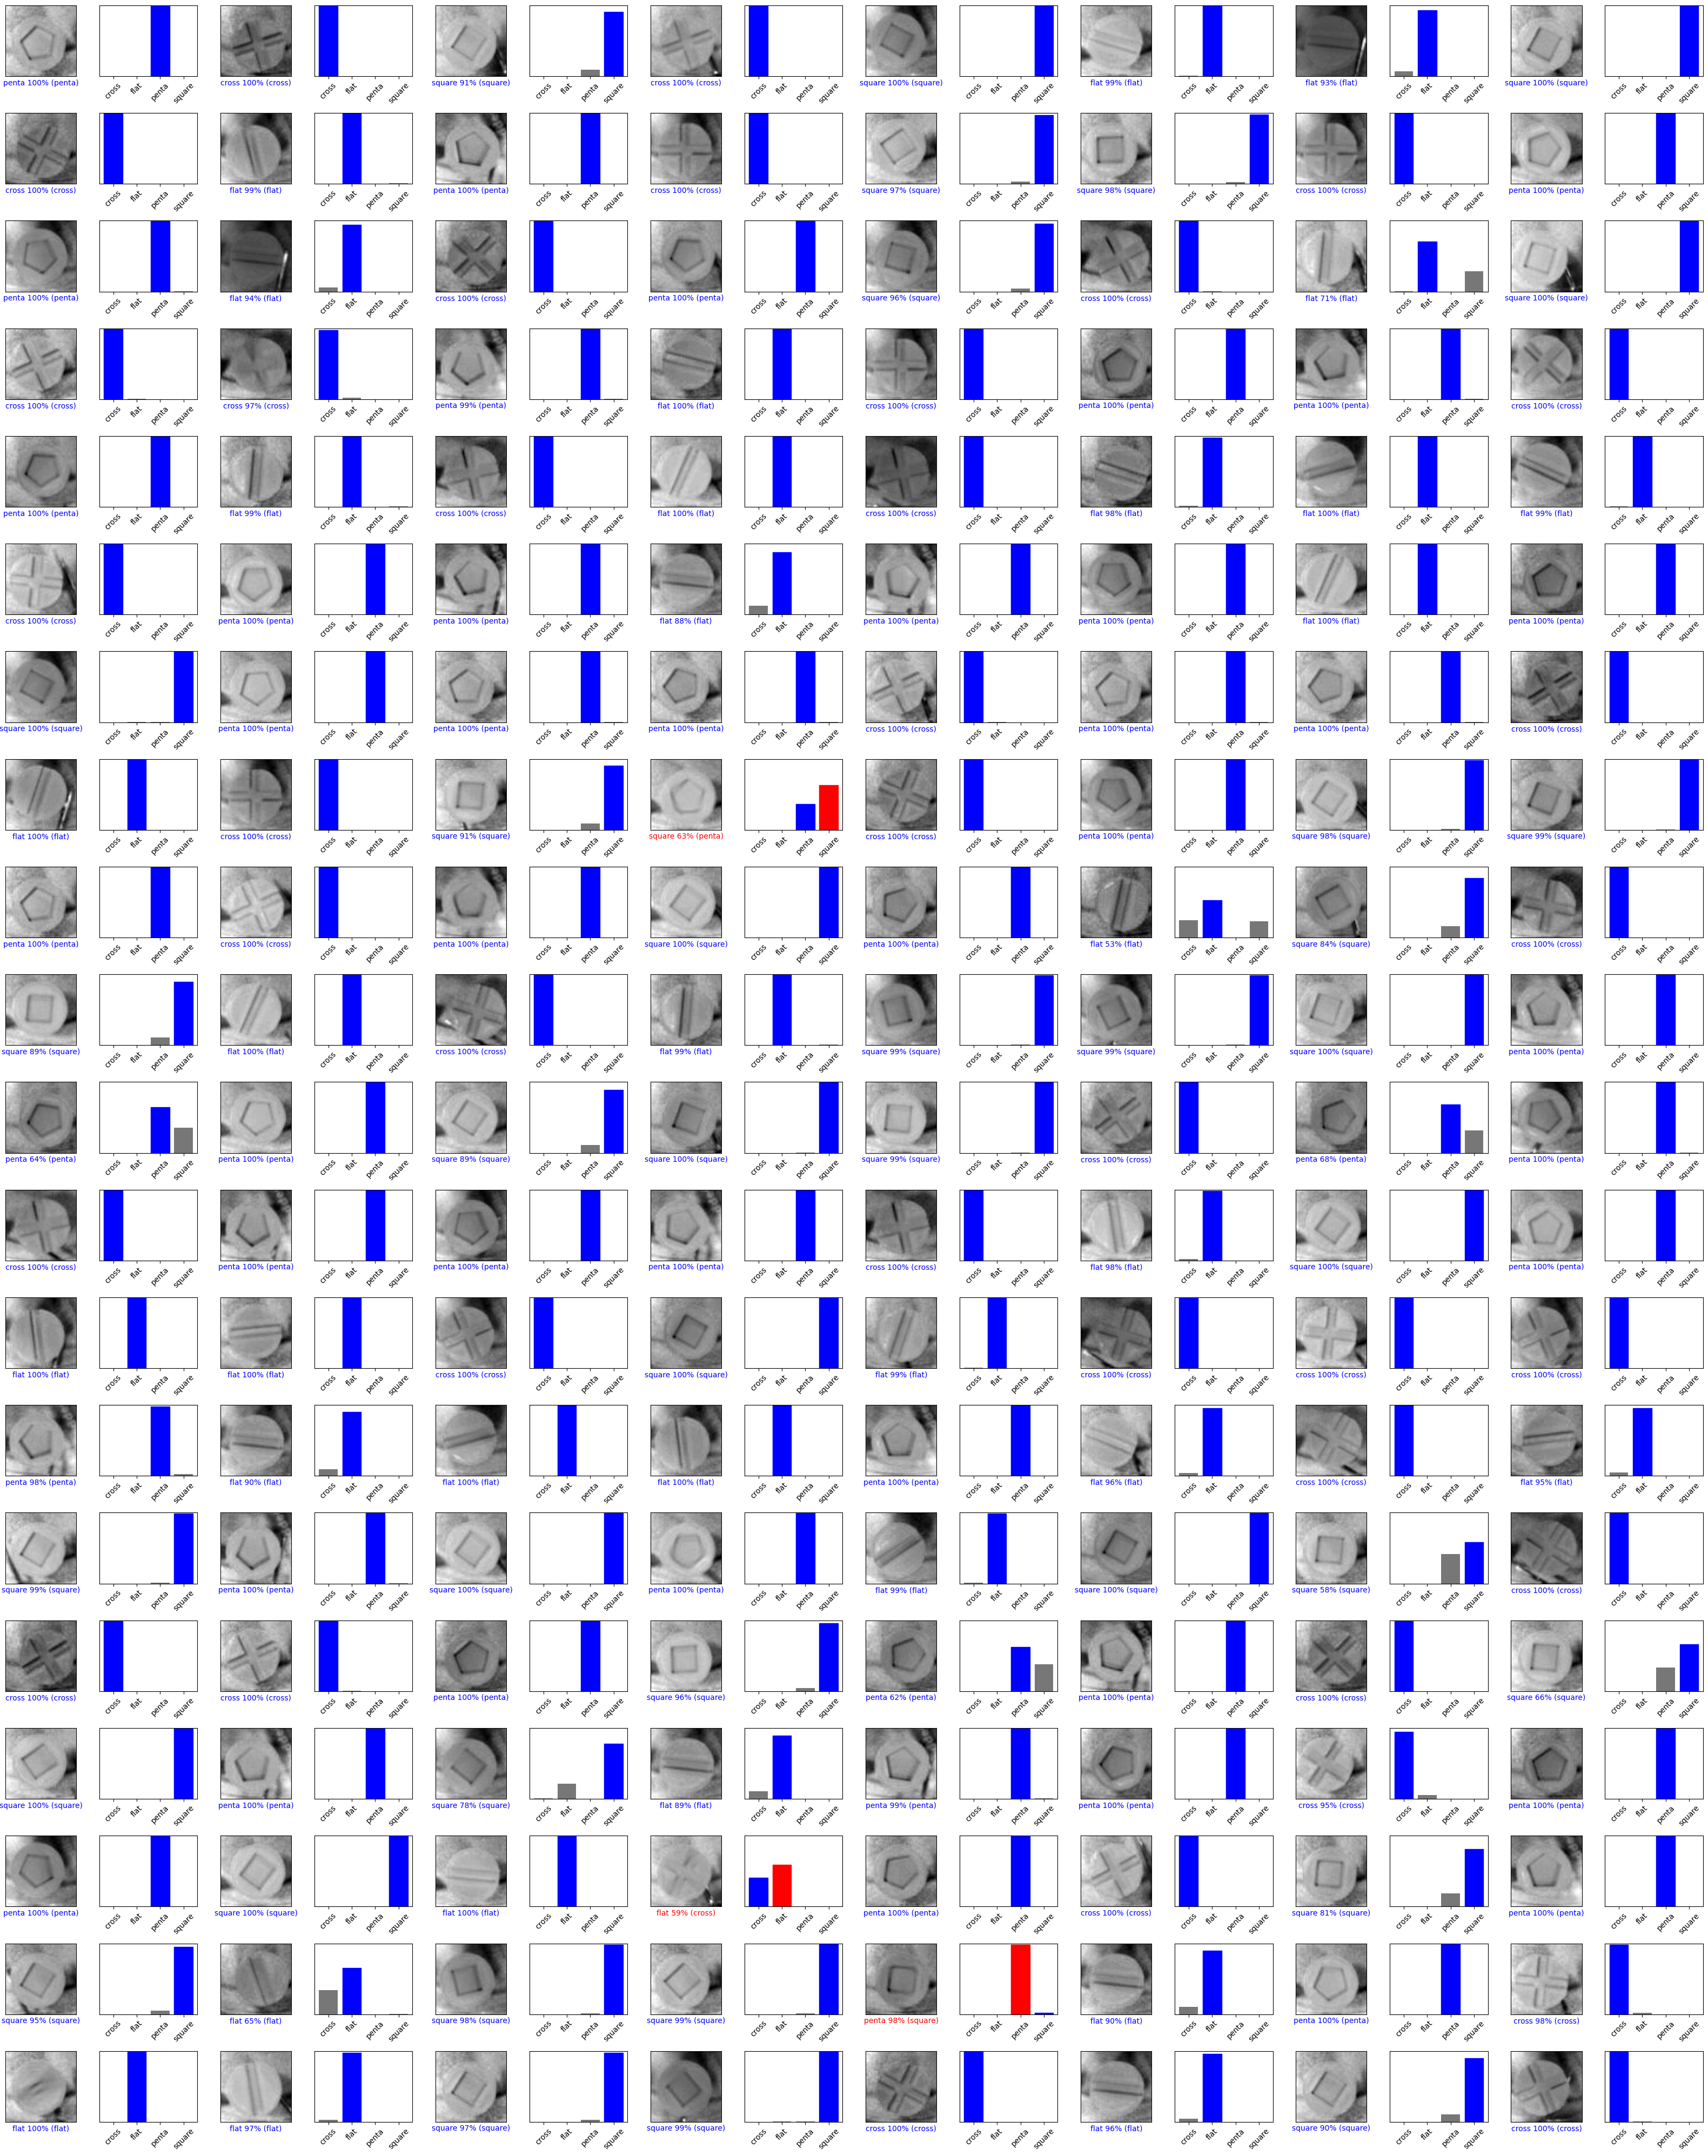

In [19]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap="gray")

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(class_names)), class_names, rotation=45)
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

image_array = []
label_array = []
for images, labels in val_ds:
   for i, image in enumerate(images):
      image_array.append(images[i].numpy().astype("uint8"))
      label_array.append(labels[i])

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], label_array, image_array)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  label_array)
plt.show()

i = 20
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], label_array, image_array)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  label_array)
plt.show()

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_cols = 8
num_rows = 20
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], label_array, image_array)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], label_array)
plt.tight_layout()
plt.show()


# Show confusion matrix

31/31 [==============================] - 2s 64ms/step
Total wrong labels:  131
8/8 [==============================] - 1s 54ms/step
Total wrong labels:  36


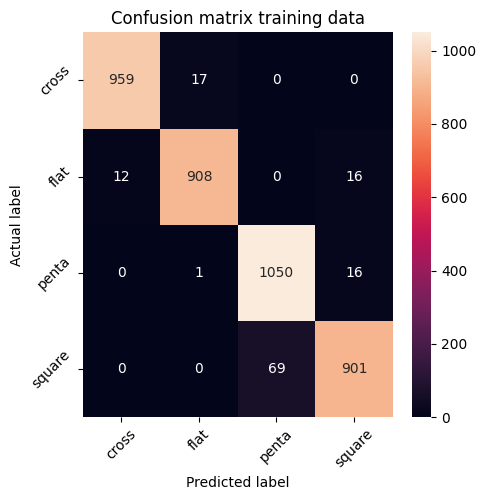

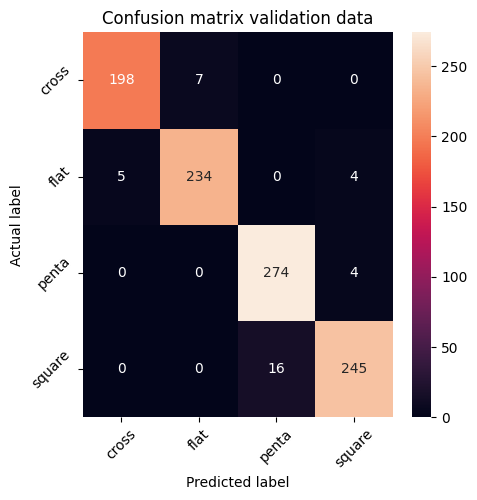

In [20]:
prop_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predicted_props = prop_model.predict(train_ds)
predicticted_classes = tf.argmax(predicted_props, axis=1)
label_array = []
for images, labels in train_ds:
   for i, image in enumerate(images):
      label_array.append(labels[i])
# test_predictions_baseline = model.predict(val_ds, batch_size=batch_size)
# print(predicticted_classes)
# print(len(label_array), len(test_predictions_baseline))
# print(len(label_array))
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions, dataset_name):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix ' + dataset_name)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.xticks([i+0.5 for i in range(len(class_names))], class_names, rotation=45)
    plt.yticks([i+0.5 for i in range(len(class_names))], class_names, rotation=45)

    num_mislabels = 0
    for index, label in enumerate(labels):
        if predictions[index].numpy() != label:
            num_mislabels += 1
    print('Total wrong labels: ', num_mislabels)
plot_cm(label_array, predicticted_classes, "training data")

prop_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predicted_props = prop_model.predict(val_ds)
predicticted_classes = tf.argmax(predicted_props, axis=1)
label_array = []
for images, labels in val_ds:
   for i, image in enumerate(images):
      label_array.append(labels[i])
plot_cm(label_array, predicticted_classes, "validation data")

# Save model

In [21]:
if SAVE_MODEL:
    # Save the entire model as a `.keras` zip archive.
    model.save('my_model.tf')

INFO:tensorflow:Assets written to: my_model.tf/assets


INFO:tensorflow:Assets written to: my_model.tf/assets


# Export weights

In [29]:
weights_filename = "../hls/weights.hpp"
open(weights_filename, 'w').close() # clear file
weights_file = open(weights_filename, "a")
for layer in model.layers:
    weights_n_bias = layer.get_weights()
    if weights_n_bias != []:
        # Weights
        weights = weights_n_bias[0]
        flat_weights = weights.flatten()
        layer_dims = weights.shape
        print(layer.name, layer_dims, layer.output_shape)
        
        # Checking how to index in flattened weights array
        correct = True
        if layer.name.partition("_")[0] == "conv2d":
            for i in range(layer_dims[0]):
                for ii in range(layer_dims[1]):
                    for iii in range(layer_dims[2]):
                        for iv in range(layer_dims[3]):
                            if weights[i][ii][iii][iv] != flat_weights[i*layer_dims[1]*layer_dims[2]*layer_dims[3] + ii*layer_dims[2]*layer_dims[3] + iii*layer_dims[3] + iv]:
                                print("Wrong at:", i, ii, iii, iv)
                                correct = False
        elif layer.name.partition("_")[0] == "dense":
            for i in range(layer_dims[0]):
                for ii in range(layer_dims[1]):
                    if weights[i][ii] != flat_weights[i*layer_dims[1] + ii]:
                        print("Wrong at:", i, ii)
                        correct = False
        if not correct:
            print("Indexing of weights wrong!")
        else:
            print("Indexing of weights correct!")

        
        # Export weight dimensions
        weights_file.write(f"constexpr int {layer.name}_weights_dims[{len(layer_dims)}] = " + "{")
        for i, dim in enumerate(layer_dims):
            weights_file.write(f"{dim}")
            if i != len(layer_dims)-1:
                weights_file.write(",")
        weights_file.write("};\n")

        # Export weights
        weights_file.write(f"constexpr float {layer.name}_weights[{len(flat_weights)}] = " + "{ \n")
        for i, num in enumerate(flat_weights):
            weights_file.write(f"{num}")
            if i != len(flat_weights)-1:
                weights_file.write(",")
            weights_file.write("\n")
        weights_file.write("};\n")


        # Bias    
        bias = weights_n_bias[1]
        flat_bias = bias.flatten()
        bias_dims = bias.shape
        
        # Checking how to index in flattened bias array
        correct = True
        for i in range(bias_dims[0]):
            if bias[i] != flat_bias[i]:
                print("Wrong at:", i)
                correct = False
        if not correct:
            print("Indexing of bias wrong!")
        else:
            print("Indexing of bias correct!")

        # Export bias dimensions
        weights_file.write(f"constexpr int {layer.name}_bias_dims[{len(bias_dims)}] = " + "{")
        for i, dim in enumerate(bias_dims):
            weights_file.write(f"{dim}")
            if i != len(bias_dims)-1:
                weights_file.write(",")
        weights_file.write("};\n")
        
        # Export bias (values added the output of each node)
        weights_file.write(f"constexpr float {layer.name}_bias[{len(flat_bias)}] = " + "{ \n")
        for i, num in enumerate(flat_bias):
            weights_file.write(f"{num}")
            if i != len(flat_bias)-1:
                weights_file.write(",")
            weights_file.write("\n")
        weights_file.write("};\n")

    # Output

    # Export output dimensions
    weights_file.write(f"constexpr int {layer.name}_output_dims[{len(layer.output_shape[1:])}] = " + "{")
    for i, dim in enumerate(layer.output_shape[1:]):
        weights_file.write(f"{dim}")
        if i != len(layer.output_shape[1:])-1:
            weights_file.write(",")
    weights_file.write("};\n")


    weights_file.write("//------------------------------------------------------------------\n")
    weights_file.write("//------------------------------------------------------------------\n")
    weights_file.write("//------------------------------------------------------------------\n")
weights_file.close()

conv2d (3, 3, 1, 32) (None, 58, 58, 32)
Indexing of weights correct!
Indexing of bias correct!
conv2d_1 (3, 3, 32, 32) (None, 27, 27, 32)
Indexing of weights correct!
Indexing of bias correct!
conv2d_2 (3, 3, 32, 32) (None, 11, 11, 32)
Indexing of weights correct!
Indexing of bias correct!
conv2d_3 (3, 3, 32, 16) (None, 3, 3, 16)
Indexing of weights correct!
Indexing of bias correct!
dense (16, 64) (None, 64)
Indexing of weights correct!
Indexing of bias correct!
dense_1 (64, 32) (None, 32)
Indexing of weights correct!
Indexing of bias correct!
dense_2 (32, 16) (None, 16)
Indexing of weights correct!
Indexing of bias correct!
dense_3 (16, 4) (None, 4)
Indexing of weights correct!
Indexing of bias correct!
